<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

---

In this lab, you will hone your exploratory data analysis (EDA) skills and practice constructing linear regressions on a data set of Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

The file is stored in the `datasets` subfolder.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression 
from sklearn import metrics
import scipy.stats as stats

In [6]:
housing = pd.read_csv('datasets/sacramento_real_estate_transactions.csv')

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [8]:
housing.shape

(985, 12)

In [9]:
housing.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

In [10]:
housing['date'] = housing['sale_date'].str[0:3]
housing

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,date
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,Wed
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,Wed
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,Wed
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,Wed
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,Thu
981,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Residential,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,Thu
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,CA,3,2,1216,Residential,Thu May 15 00:00:00 EDT 2008,235000,38.708824,-121.256803,Thu
983,8304 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Residential,Thu May 15 00:00:00 EDT 2008,235301,38.417000,-121.397424,Thu


### 2. Conduct exploratory data analysis on this data set. 

If you discover any issues with the data, fix them to the best of your ability. **Report any notable findings.**

_**Note:** Zip codes often have leading zeros — e.g., 02215 = Boston, MA — which will often get knocked off automatically by many software programs like Python or Excel._

In [12]:
housing['zip'] = '0' + housing['zip'].astype('str')

In [13]:
housing['price'].sum()

230210212

In [14]:
condition = (housing['price'] < 0) & (housing['sq__ft'] < 0)

housing['price'] = np.where(condition, housing['price'] * -1, housing['price'])
housing['sq__ft'] = np.where(condition, housing['sq__ft'] * -1, housing['sq__ft'])


In [15]:
print(housing[housing['sq__ft'] ==0].shape[0])
print(housing[(housing['beds'] ==0) & (housing['baths'] ==0) & (housing['sq__ft'] ==0)].shape[0])

171
108


In [16]:
# From exploration, the sq__ft data has the highest correlation with price. 
# Out of 171 observations with sq__ft = 0, 108 observations have beds and baths equal to 0 as well, 
# leaving only 63 observations that can affect the model. This represents roughly 6.4% of all observations. 
# Thus, we can drop these 171 observations.

housing= housing[(housing['beds'] !=0) & (housing['baths'] !=0) & (housing['sq__ft'] !=0)]

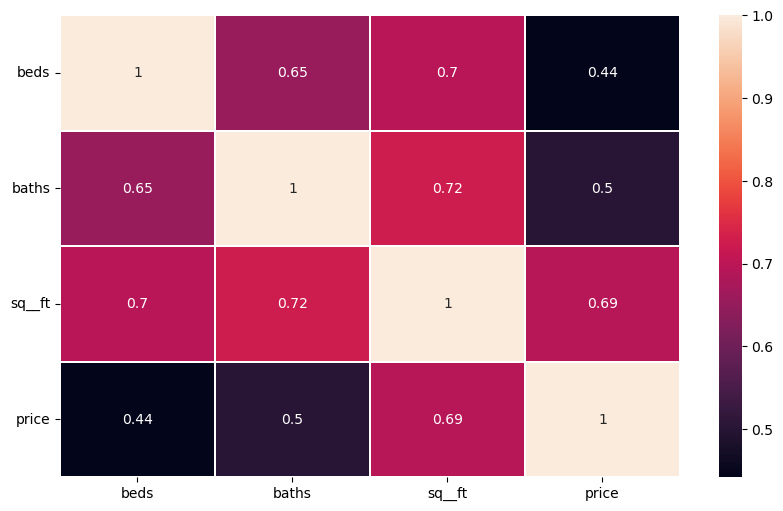

In [17]:
test_housing = housing[['beds', 'baths','sq__ft', 'price']]

plt.figure(figsize = (10,6))
sns.heatmap(test_housing.corr(), annot = True, linewidth = 0.1)
plt.yticks(rotation = 0)
plt.show()

In [18]:
housing.describe()

,beds,baths,sq__ft,price,latitude,longitude
count,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000
mean,3.244472,1.960688,1591.146192,229448.369779,38.380272,-121.181916
std,0.852137,0.669804,663.841930,119825.576060,5.612236,5.610919
min,1.000000,1.000000,484.000000,2000.000000,-121.503471,-121.550527
25%,3.000000,2.000000,1144.000000,148750.000000,38.473785,-121.451322
50%,3.000000,2.000000,1418.500000,207986.500000,38.591547,-121.404863
75%,4.000000,2.000000,1851.000000,284973.250000,38.674704,-121.325720
max,8.000000,5.000000,5822.000000,884790.000000,39.008159,38.668433


When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work. Use the pandas `to_csv` method to export your cleaned dataset.

```python
# example -- your dataframe name may be different
dataframe.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

```

In [20]:
housing.to_csv('./datasets/sacramento_cleaned_dataframe.csv',index = False)

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR (Simple Linear Regression) model.

For each of the variables you believe should be considered, generate a plot showing the relationship between the independent and dependent variables.

In [22]:
housing.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,date
0,3526 HIGH ST,SACRAMENTO,095838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,Wed
1,51 OMAHA CT,SACRAMENTO,095823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,Wed
2,2796 BRANCH ST,SACRAMENTO,095815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,Wed
3,2805 JANETTE WAY,SACRAMENTO,095815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,Wed
4,6001 MCMAHON DR,SACRAMENTO,095824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,Wed


In [23]:
housing_slr = housing[['beds','baths','sq__ft','price']]
housing_slr.head()

,beds,baths,sq__ft,price
0,2,1,836,59222
1,3,1,1167,68212
2,2,1,796,68880
3,2,1,852,69307
4,2,1,797,81900


### 4. Which variable would be the best predictor of `y` in an SLR (Simple Linear Regression) model? Why?

In [25]:
# sq__ft is the best predictor for SLR Model because it's numerical data that will making impact with price of house.

### 5. Write a function that will take in two lists, `x` and `y`, and returns the intercept and slope coefficients that minimize SSE (Sum of Squared Errors). 

`y` is the target variable, and `x` is the predictor variable.

**Don't use scikit-learn for this**. Instead, use numpy and scipy.

The slope and intercept of simple linear regression can be calculated by using certain summary statistics. In particular, we'll need to know:

- $\bar{x}$, the mean of `x`
- $\bar{y}$, the mean of `y`
- $s_{x}$, the standard deviation of `x`
- $s_{y}$, the standard deviation of `y`
- $r_{xy}$, the correlation of `x` and `y`

Given these summary statistics, the **coefficient on `X`** (or the slope) can be given by $\beta_{1} = r_{xy} * \frac{s_{y}}{s_{x}}$. The **intercept of the model** can be given by $\beta_{0} = \bar{y} - \beta_{1}\bar{x}$.

Your function should take in `x` and `y`, then use the above summary statistics to calculate the slope and intercept.

- **Test your function on price and the variable you determined was the best predictor in Question #4.**
- **Report the slope and intercept.**

In [27]:
def lin_reg(X, y):  
    X_bar = X.mean()
    y_bar = y.mean()
    X_std = X.std()
    y_std = y.std()
    r_xy = housing_slr[['sq__ft', 'price']].corr().iloc[0, 1]  
    b1 = r_xy * y_std / X_std
    b0 = y_bar - (b1 * X_bar)
    return b0,b1

beta0 = lin_reg(X = housing_slr['sq__ft'],y = housing_slr['price'])[0]
beta1 = lin_reg(X = housing_slr['sq__ft'],y = housing_slr['price'])[1]

In [28]:
# def lin_reg(x, y):
#   beta1 = (stats.pearsonr(x,y)[0]*np.std(y)/np.std(x))
#    beta0 = np.mean(y) - (beta1*np.mean(x))
#    return beta0, beta1
# lin_reg(x= housing_slr['sq__ft'], y= housing_slr['price'])

### 6. Now interpret the intercept and the slope.

In [30]:
# The slope represents the rate of change of the dependent variable y with respect to the independent variable 
# The y-intercept (b) is the value of the dependent variable (y) when the independent variable (x) is zero. It is a constant.

### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

In [32]:
# This model will predict estimate  price base on squared foot of house

### 8: Using the model you came up with in Question #5, calculate and plot the residuals.

In [66]:
housing_slr.loc[:, 'predictions'] = beta0 + beta1 * housing_slr['sq__ft']
housing_slr.loc[:, 'residuals'] = housing_slr['price'] - housing_slr['predictions']

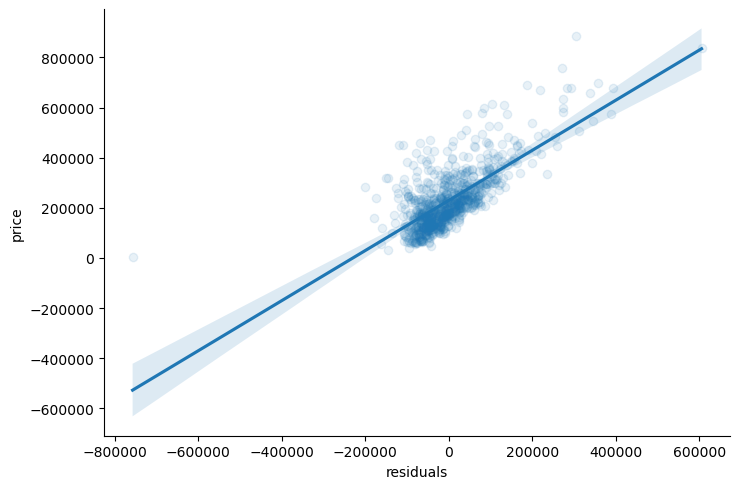

In [35]:
sns.lmplot(x= 'residuals', y='price', data= housing_slr, aspect =1.5, scatter_kws = {'alpha':0.1})
plt.show()

---

## Dummy Variables

It is important to be cautious with categorical variables, which represent distinct groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.



#### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occurred in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tuesday, Wednesday, Thursday, Friday or Saturday, it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted as the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to*, is often referred to as the **reference category**.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

In [38]:
housing_mlr = housing

In [39]:
housing_mlr = pd.get_dummies(data=housing_mlr, columns=["type"], prefix="type")
housing_mlr = pd.get_dummies(data=housing_mlr, columns=["date"], prefix="date")


### 10. Check the dummy columns you've created. Do they all make sense?

Use `.head()` on the new dataframe you've created. Depending on how you cleaned the data earlier in this notebook, there may be a dummy column that needs to be removed. Check that all the columns you've created make sense, and if any of the columns seem to be errors, drop them. If there don't appear to be any errors, then move on to the next step!

In [41]:
housing_mlr.head()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type_Condo,type_Multi-Family,type_Residential,date_Fri,date_Mon,date_Thu,date_Tue,date_Wed
0,3526 HIGH ST,SACRAMENTO,095838,CA,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,False,False,True,False,False,False,False,True
1,51 OMAHA CT,SACRAMENTO,095823,CA,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,False,False,True,False,False,False,False,True
2,2796 BRANCH ST,SACRAMENTO,095815,CA,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,False,False,True,False,False,False,False,True
3,2805 JANETTE WAY,SACRAMENTO,095815,CA,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,False,False,True,False,False,False,False,True
4,6001 MCMAHON DR,SACRAMENTO,095824,CA,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,False,False,True,False,False,False,False,True


### 11. Build what you think may be the best MLR (Multiple Linear Regression) model predicting `price`. 

Choose at least three variables, and build a model that uses them to predict price. At least one of the variables you choose should be a dummy-coded variable. (This can be one we created before or a new one.) 

You may need to load in the scikit-learn API:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

In [43]:
feature_cols = ['beds', 'baths','sq__ft', 
                'type_Condo','type_Multi-Family', 'type_Residential', 
                'date_Fri', 'date_Mon', 'date_Thu',	'date_Tue',	'date_Wed']

X = housing_mlr[feature_cols]
y = housing_mlr['price']

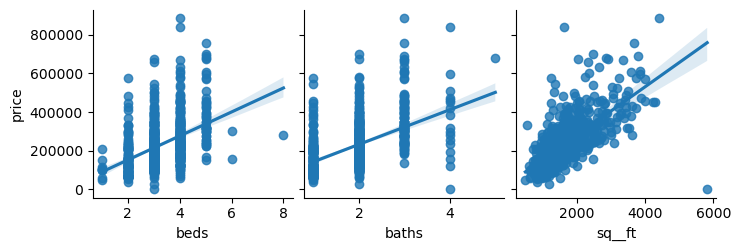

In [44]:
sns.pairplot(housing_mlr, x_vars=feature_cols[0:3], y_vars='price', kind='reg')
plt.show()

In [45]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [46]:
print(lr.coef_)
print(lr.intercept_)

[-13643.45345466   8534.01760366    127.49083281  -2809.83171691
 -27873.7868477   30683.61856461   3302.21698027  11403.32129679
 -24464.1362682   17126.43738564  -7367.83939451]
23994.36770310544


In [47]:
beta_list = pd.DataFrame(lr.coef_, index = feature_cols)
beta_list

,0
beds,-13643.453455
baths,8534.017604
sq__ft,127.490833
type_Condo,-2809.831717
type_Multi-Family,-27873.786848
type_Residential,30683.618565
date_Fri,3302.216980
date_Mon,11403.321297
date_Thu,-24464.136268
date_Tue,17126.437386


In [48]:
housing_mlr['predict_price'] = lr.predict(X)
housing_mlr['residuals'] = housing_mlr['price'] - housing_mlr['predict_price']
housing_mlr['residuals'].mean()

-1.487370205159855e-11

In [49]:
housing_mlr.head()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,...,type_Condo,type_Multi-Family,type_Residential,date_Fri,date_Mon,date_Thu,date_Tue,date_Wed,predict_price,residuals
0,3526 HIGH ST,SACRAMENTO,095838,CA,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,...,False,False,True,False,False,False,False,True,135139.593798,-75917.593798
1,51 OMAHA CT,SACRAMENTO,095823,CA,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,...,False,False,True,False,False,False,False,True,163695.606004,-95483.606004
2,2796 BRANCH ST,SACRAMENTO,095815,CA,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,...,False,False,True,False,False,False,False,True,130039.960486,-61159.960486
3,2805 JANETTE WAY,SACRAMENTO,095815,CA,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,...,False,False,True,False,False,False,False,True,137179.447123,-67872.447123
4,6001 MCMAHON DR,SACRAMENTO,095824,CA,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,...,False,False,True,False,False,False,False,True,130167.451318,-48267.451318


### 12. Plot the true price vs the predicted price to evaluate your MLR (Multiple Linear Regression) visually.

You can use matplotlib or seaborn.

In [51]:
predict = housing_mlr['predict_price']
actual = housing_mlr['price']
residuals = housing_mlr['residuals']

Text(-13.749999999999991, 0.5, 'Price')

<Figure size 600x600 with 0 Axes>

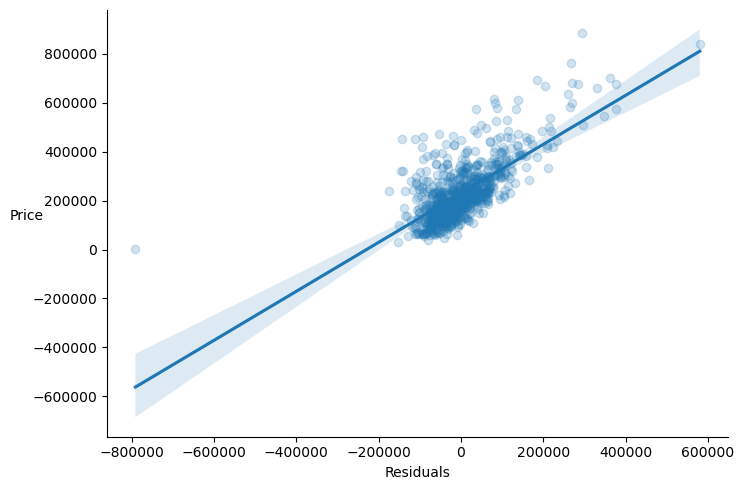

In [52]:
plt.figure(figsize=(6, 6)) 

sns.lmplot(x= 'residuals', y='price', data= housing_mlr, aspect =1.5, scatter_kws = {'alpha':0.2})
plt.xlabel('Residuals')
plt.ylabel('Price', rotation = 0)

### 13. List the five assumptions for an MLR (Multiple Linear Regression) model. 

Indicate which ones are the same as the assumptions for an SLR model. 

In [54]:
# sq__ft is the same feature used in SLR.

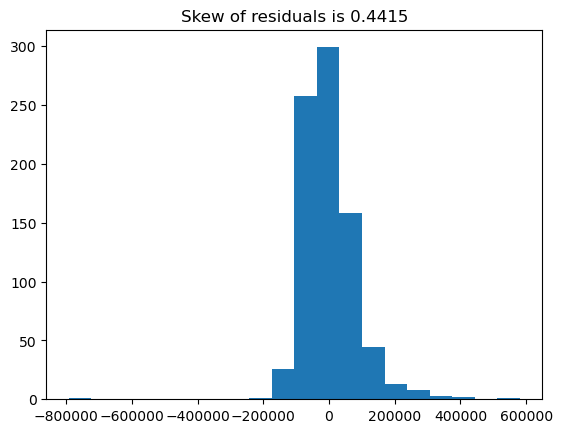

In [55]:
# N - Normality assumption
plt.hist(residuals, bins = 20)
plt.title(f'Skew of residuals is {pd.Series(residuals).skew():.4f}')
plt.show()

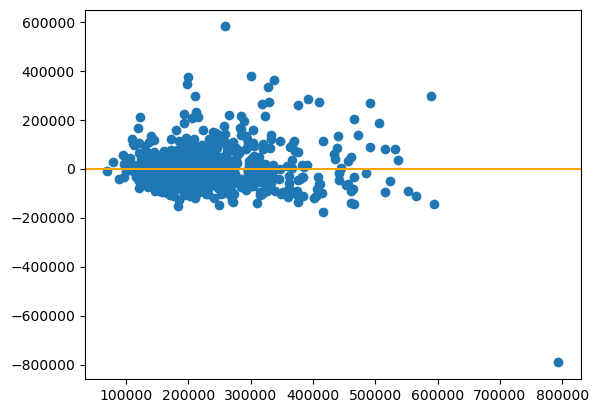

In [56]:
# Residuals - check the L and E assumptions
plt.scatter(predict, residuals)
plt.axhline(0, color = 'orange')
plt.show()

### 14. Pick at least two assumptions and explain whether or not you believe them to be met for your model, and explain why.

In [58]:
# Linearity
# Assessment: For my model, I believe this assumption holds true.
# Reason: From the scatter plot created between predicted values and actual values, 
# it is clear that the data points are distributed in a linear pattern. 
# This indicates that the relationship between the independent and dependent variables is linear.

# Normality (of residuals)
# Assessment: For my model, I believe this assumption is not correct.
# Reason: When examining the distribution of the residuals, it was found that some values exhibit right skewness, 
# indicating a non-normal distribution.

### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [61]:
def r2_adj(y_true, y_preds, p):
    n = len(actual)
    actual_mean = np.mean(actual)
    numerator = np.sum(np.square(residuals)) / (n - p - 1)
    denominator = np.sum(np.square(actual - actual_mean)) / (n - 1)
    return 1 - numerator / denominator

### 17. Metrics, metrics, everywhere...

Calculate and interpret at least three regression metrics. How well does your model perform?

In [63]:
def Tuning_Model(features):
    X = housing_mlr[features]
    y = housing_mlr['price']
    lr = LinearRegression()
    lr.fit(X,y)
    housing_mlr['predict_price'] = lr.predict(X)
    housing_mlr['residuals'] = housing_mlr['price'] - housing_mlr['predict_price']

    return housing_mlr

In [64]:
features1 = ['beds', 'baths','sq__ft']

features2 = ['beds', 'baths','sq__ft',  
                'date_Fri', 'date_Mon', 'date_Thu',	'date_Tue',	'date_Wed']

features3 = ['beds', 'baths','sq__ft', 
                'type_Condo','type_Multi-Family', 'type_Residential']

features4 = ['beds', 'baths','sq__ft', 
                'type_Condo','type_Multi-Family', 'type_Residential', 
                'date_Fri', 'date_Mon', 'date_Thu',	'date_Tue',	'date_Wed']


In [65]:
def king_of_metrics(y_true, y_pred, p, time, features):
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = metrics.root_mean_squared_error(y_true, y_pred)
    msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)

    feature_set = set()
    for feature in features: 
        part = feature.split('_')[0]
        if part in ['type', 'date']:
            part = feature.split('_')[0]
        else: 
            part = feature     
        feature_set.add(part)
    features = ', '.join(feature_set)
    
    print(f"Regression Metric number {time} the features is {features}")
    print(f"The mean squared error is {mse:.2f}")
    print(f"The root mean squared error is {rmse:.2f}")
    print(f"The mean squared log error is {msle:.2f}")
    print(f"The median absolute error is {mae:.2f}")
    print(f"The R^2 is {r2:.2f}")
    print(f"Adjusted R^2 = {r2a:.2f}\n")

king_of_metrics(Tuning_Model(feature1)['price'],Tuning_Model(feature1)['predict_price'], 30, 1, features1)

NameError: name 'feature1' is not defined

### 18. Model Iteration

Adjust your model by adding or removing a variable. Then calculate the same regression metrics as you used in question 17. Has your model performance increased or decreased?

In [ ]:
king_of_metrics(Tuning_Model(feature2)['price'],Tuning_Model(feature2)['predict_price'], 30, 2, features2)
king_of_metrics(Tuning_Model(feature3)['price'],Tuning_Model(feature3)['predict_price'], 30, 3, features3)
king_of_metrics(Tuning_Model(feature4)['price'],Tuning_Model(feature4)['predict_price'], 30, 4, features4)

### 19. Bias vs. Variance

_(To be completed after the bias-variance tradeoff lecture.)_ At this point, do you think your model is high bias, high variance or in the sweet spot?

In [ ]:
# high bias beacuse underfitting occurs in the model and patterns in the data cannot be identified, 
# resulting in substandard data performance.

# less variance because The variance of model predictions between different data sets does not differ much.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=874)

In [ ]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)